In [1]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import pickle
import pandas as pd
import re
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset

In [2]:
import pandas as pd
df_training =  pd.read_csv("/root/InvestorUpdate/training_data_policy_chunk_votes_20.csv")

In [3]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import torch

# === Step 1: Add [Policy] [SEP] [Chunk] and Label column ===
# Create input and label
df_training["Input"] = df_training.apply(lambda x: f"{x['Policy']} [SEP] {x['Chunk']}", axis=1)
df_training["Label"] = df_training["Vote"].apply(lambda v: 1 if v == 1 else 0)

# Drop duplicates based on the exact model input
df_training = df_training.drop_duplicates(subset="Input")

# === Step 2: Downsample "For" votes to match "Against" votes ===
from sklearn.model_selection import train_test_split

# Step 1: Downsample majority class
df_majority = df_training[df_training["Label"] == 1]
df_minority = df_training[df_training["Label"] == 0]

# Choose desired downsampling ratio
target_ratio = 1.0  # for 1:1 balance; change to 2.0 for 2:1, etc.
n_majority = int(len(df_minority) * target_ratio)

df_majority_downsampled = df_majority.sample(n=n_majority, random_state=42)
df_balanced = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=42)

# Step 2: Create input/label
df_balanced["Input"] = df_balanced.apply(lambda x: f"{x['Policy']} [SEP] {x['Chunk']}", axis=1)
df_balanced["Label"] = df_balanced["Vote"].apply(lambda v: 1 if v == 1 else 0)

# Step 3: Split data
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df_balanced["Input"].tolist(),
    df_balanced["Label"].tolist(),
    test_size=0.15,
    stratify=df_balanced["Label"],
    random_state=42
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts,
    train_val_labels,
    test_size=0.1765,  # ≈15% of total
    stratify=train_val_labels,
    random_state=42
)

# === Step 4: Tokenize ===
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# === Step 5: Wrap as PyTorch Dataset ===
class VoteDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = VoteDataset(train_encodings, train_labels)
val_dataset = VoteDataset(val_encodings, val_labels)
test_dataset = VoteDataset(test_encodings, test_labels)


In [4]:
train_set = set(train_texts)
val_set = set(val_texts)
test_set = set(test_texts)
print("🔍 Train ∩ Val:", len(train_set & val_set))
print("🔍 Train ∩ Test:", len(train_set & test_set))
print("🔍 Val ∩ Test:", len(val_set & test_set))

🔍 Train ∩ Val: 0
🔍 Train ∩ Test: 0
🔍 Val ∩ Test: 0


In [5]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import numpy as np

# === Model ===
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=1
).to("cuda" if torch.cuda.is_available() else "cpu")

# === Compute pos_weight ===
num_pos = sum(train_dataset.labels)
num_neg = len(train_dataset.labels) - num_pos
pos_weight = torch.tensor([num_neg / num_pos])

# === Custom loss function ===
def compute_loss(model, inputs, return_outputs=False, **kwargs):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs.logits.view(-1)
    loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(logits.device))
    loss = loss_fct(logits, labels)
    return (loss, outputs) if return_outputs else loss

# === Training arguments ===
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # fix typo: was eval_strategy
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss"
)

# === Metrics with class-wise reporting ===
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()
    labels = np.array(labels).astype(int)

    report = classification_report(labels, preds, output_dict=True, zero_division=0)
    return {
        "accuracy": report["accuracy"],
        "precision": report["1"]["precision"],
        "recall": report["1"]["recall"],
        "f1": report["1"]["f1-score"],
        "precision_against": report["0"]["precision"],
        "recall_against": report["0"]["recall"],
        "f1_against": report["0"]["f1-score"],
    }

# === Trainer with custom loss ===
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
trainer.compute_loss = compute_loss  # attach custom loss

# === Train ===
trainer.train()



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Against,Recall Against,F1 Against
1,0.426500,0.452159,0.828591,0.816600,0.847222,0.831629,0.841499,0.809986,0.825442
2,0.349500,0.412740,0.828591,0.816600,0.847222,0.831629,0.841499,0.809986,0.825442
3,0.381300,0.413429,0.828591,0.816600,0.847222,0.831629,0.841499,0.809986,0.825442
4,0.351200,0.412286,0.828591,0.816600,0.847222,0.831629,0.841499,0.809986,0.825442


TrainOutput(global_step=3360, training_loss=0.3957046219280788, metrics={'train_runtime': 918.7453, 'train_samples_per_second': 29.253, 'train_steps_per_second': 3.657, 'total_flos': 7071309232852992.0, 'train_loss': 0.3957046219280788, 'epoch': 4.0})

In [6]:
import torch
from sklearn.metrics import classification_report

# === Step 1: Get predictions ===
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
labels = predictions.label_ids
threshold = 0.59
probs = torch.sigmoid(torch.tensor(logits)).numpy()
preds = (probs > threshold).astype(int).flatten()

# === Step 2: Binary report ===
print("🔍 Full Classification Report:")
print(classification_report(labels, preds, target_names=["Against", "For"]))

# === Step 3: Focus on 'Against' class ===
against_indices = (labels == 0)
against_labels = labels[against_indices]
against_preds = preds[against_indices]

accuracy_against = (against_labels == against_preds).mean()
print(f"\n🎯 Accuracy on 'Against' votes: {accuracy_against:.3f}")

🔍 Full Classification Report:
              precision    recall  f1-score   support

     Against       0.85      0.81      0.83       720
         For       0.82      0.86      0.84       720

    accuracy                           0.84      1440
   macro avg       0.84      0.84      0.84      1440
weighted avg       0.84      0.84      0.84      1440


🎯 Accuracy on 'Against' votes: 0.812


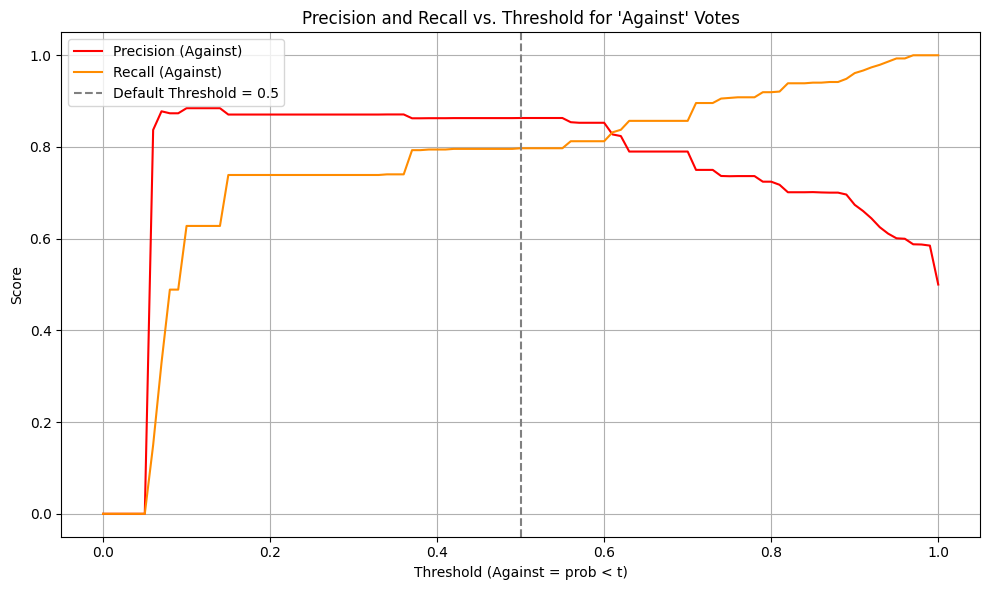

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# === Get logits and true labels from test set ===
outputs = trainer.predict(test_dataset)
logits = outputs.predictions
labels = outputs.label_ids

# Convert logits to probabilities
probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()

# === Flip the problem: predict "Against" when prob < threshold ===
thresholds = np.linspace(0.0, 1.0, 101)
precisions = []
recalls = []

for t in thresholds:
    # Predict 0 ("Against") if prob < threshold
    preds = (probs < t).astype(int)  # 'Against' = 1 here
    flipped_labels = (labels == 0).astype(int)  # 'Against' = 1 here

    p = precision_score(flipped_labels, preds, zero_division=0)
    r = recall_score(flipped_labels, preds, zero_division=0)
    precisions.append(p)
    recalls.append(r)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision (Against)", color="red")
plt.plot(thresholds, recalls, label="Recall (Against)", color="darkorange")
plt.axvline(x=0.5, color='gray', linestyle='--', label="Default Threshold = 0.5")
plt.xlabel("Threshold (Against = prob < t)")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold for 'Against' Votes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
from sklearn.metrics import f1_score

best_f1 = 0
best_threshold = 0
f1_scores = []

for t in thresholds:
    preds = (probs < t).astype(int)
    flipped_labels = (labels == 0).astype(int)
    f1 = f1_score(flipped_labels, preds, zero_division=0)
    f1_scores.append(f1)
    if f1 > best_f1:
        
        best_f1 = f1
        best_threshold = t

print(f"🎯 Best Threshold: {best_threshold:.2f}  |  F1 (Against): {best_f1:.3f}")

🎯 Best Threshold: 0.56  |  F1 (Against): 0.833


In [12]:
model.save_pretrained("CG_Sphere_Transformer")
tokenizer.save_pretrained("CG_Sphere_Transformer")


('CG_Sphere_Transformer/tokenizer_config.json',
 'CG_Sphere_Transformer/special_tokens_map.json',
 'CG_Sphere_Transformer/vocab.txt',
 'CG_Sphere_Transformer/added_tokens.json',
 'CG_Sphere_Transformer/tokenizer.json')

In [ ]:
from huggingface_hub import HfApi
import os

# Set token (if not done via environment)

api = HfApi(token=token)

api.upload_folder(
    folder_path="./CG_Sphere_Transformer",   # This is the folder where you saved model/tokenizer
    repo_id="Jaymin123321/CGSPHERE",  # Your HF model repo
    repo_type="model"
)


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/Jaymin123321/CGSPHERE/commit/9296fccd81ecbb87f1846ecbf8f018c74f85e707', commit_message='Upload folder using huggingface_hub', commit_description='', oid='9296fccd81ecbb87f1846ecbf8f018c74f85e707', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Jaymin123321/CGSPHERE', endpoint='https://huggingface.co', repo_type='model', repo_id='Jaymin123321/CGSPHERE'), pr_revision=None, pr_num=None)

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from huggingface_hub import login

model = AutoModelForSequenceClassification.from_pretrained("Jaymin123321/CGSPHERE")
tokenizer = AutoTokenizer.from_pretrained("Jaymin123321/CGSPHERE")

# Move model to GPU if available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


config.json:   0%|          | 0.00/710 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e